## Analysis of Trove Government Gazettes

Attempting to reproduce the work described [on the NLA blog](https://www.nla.gov.au/blogs/trove/2018/07/23/digital-tools-for-big-research) where a collection of Certificates of Naturalisation were selected from the Trove Government Gazettes and analysed to give a picture of the number of arrivals over time. 

In that exercise the work was done manually to identify names and generate counts.  I will attempt to implement an automated process to derive the same data. 

In [1]:
# install all requirements quietly
!pip install -q -r requirements.txt

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import requests
import datetime
import re
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Trove requires an API key, we read it here from a file `secret.json`.   

In [4]:
TROVE_API_KEY = utils.secret('trove')

In [5]:
## Define a function to query the Trove API for a given query string
## this will run multiple queries if needed to get the requested number
## of results (100 at a time)

def trove_query(q, n=100):
    """A simple Trove API interface, 
    q is a query term, we search the 
    newspaper zone and return
    the decoded JSON response (a Python dictionary)"""
    
    TROVE_API_URL = "http://api.trove.nla.gov.au/result"
    qterms = {
        'zone': 'newspaper',
        'encoding': 'json',
        'include': 'articleText',
        's': 0,
        'n': n,
        'key': TROVE_API_KEY,
        'q': q
    }
    r = requests.get(TROVE_API_URL, params=qterms).json()
    articles = r['response']['zone'][0]['records']['article']
    remaining = n-100
    while remaining > 0:
        qterms['n'] = remaining
        qterms['s'] += 100
        r = requests.get(TROVE_API_URL, params=qterms)
        r = r.json()
        art = r['response']['zone'][0]['records']['article']
        if len(art) > 0:
            articles.extend(art)
            remaining -= 100
        else:
            # no more articles
            remaining = 0
        
    return articles

#articles = trove_query('"Certificate of Naturalisation"', 110)
#len(articles)

We use the function defined above to query the API for "Certificates of Naturalisation" - these are the articles in the Government Gazzettes that contain lists of names of recently naturalised citizens.  Our goal is to extract from these the details of the names and addresses of these people. 

In [6]:
articles = trove_query('"Certificates of Naturalisation"', 1000)
len(articles)

1000

We can take a look at one of these documents, they are encoded in HTML so we'll use the notebook facility to embed one of the documents below.

In [10]:
from IPython.core.display import display, HTML
display(HTML(articles[3]['articleText']))

We will work through one example using the first article in this list.  The first step is to extract the text from the HTML markup.  We observe that each line is enclosed in &lt;span> tags, so we use a regular expression to extract the texts into a list of lines.  We can then take a look at the first 10 lines.

In [18]:
lines = re.findall('<span>([^<]+)</span>', articles[3]['articleText'])
lines[:10]

['  Department  of  Immigration,',
 '  Canberra,  A.C.T.  2600',
 '  CERTIFICATES  OF  NATURALISATION',
 '  THE  Minister  of  State  for  Immigration  has  granted  Certificates',
 '  of  Naturalisation  to  the  following  people  living  in  the  Territory  of',
 '  Papua  and  New  Guinea.',
 '  P.  R.  HEYDON,  Secretary',
 '  Aga,  Ivan,  c/o  Dowsett  Engineering,  Pty  Ltd,  Post  Office,  Rabaul,',
 '  10.7.67.',
 '  Chan,  Joseph  Kwok  Pang,  Samoa  Street,  Rabaul,  12.7.67.']

## Trying Spacy NER

We'll try to use NER on this text to find names. However, given the lack of context in the text (this is just a list of names) it may not be very successful.

In [12]:
import spacy
from spacy import displacy
from IPython.core.display import display, HTML
# download the spacy models we need
model = 'en_core_web_md'
spacy.cli.download(model)
nlp = spacy.load(model)


    Linking successful
    /opt/conda/lib/python3.6/site-packages/en_core_web_md -->
    /opt/conda/lib/python3.6/site-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')



Applying the NER model and displaying the output for this text we see that while many  names are highlighted (in purple) there are also many missed and many false positives shown.   The lack of context in the text removes the usual cues to names and leaves the system guessing based on capitalisation.  

In [13]:
doc = nlp("\n".join(lines))
display(HTML(displacy.render(doc, style='ent')))

## Regular Expression based Extraction

In this case the text is very structured as a list of names, addresses and dates.  We can try to use regular expressions to locate these fields in the text.

First find the lines in the text containg date-like words (digits + .).

In [19]:

datelines = [m for m in lines if re.search('\d+', m)]
datelines[:5]

['  Canberra,  A.C.T.  2600',
 '  10.7.67.',
 '  Chan,  Joseph  Kwok  Pang,  Samoa  Street,  Rabaul,  12.7.67.',
 '  Kai,  Louis  Dunston,  Gurney  Street,  Lae,  5.7.67.',
 '  Lam,  Leonard  Tin  Chung,  Vulcan  Street,  Rabaul,  10.7.67;  Lam,']

Now join all of these lines together into one big string since records seem to flow over lines. 

We can then look for the individual records. Each record looks like:

> Cianetti,  Carla,  68  West  Street,  Mt  Isa,  10.7.67.

which we can generalise to:

> Last, First, Address, Date

So let's write a regular expression pattern to match that

In [20]:
text = " ".join(datelines)
pattern = "\W+(.+?)(\d\d?[ .]+\d\d?[ .]+\d\d)[.;]?"
matches = re.findall(pattern, text)
matches[:3]

[('Canberra,  A.C.T.  2600   ', '10.7.67'),
 ('Chan,  Joseph  Kwok  Pang,  Samoa  Street,  Rabaul,  ', '12.7.67'),
 ('Kai,  Louis  Dunston,  Gurney  Street,  Lae,  ', '5.7.67')]

We can then just split the name+address string at the comma character to get three fields.  We ignore any records where there are less than three fields and convert the result into a dataframe.

In [22]:
res = []
for text, date in matches:
    n = text.split(',')
    if len(n) > 2:
        res.append({'first': n[1].strip(), 'last': n[0].strip(), 'addr': " ".join(n[2:]).strip(), 'date': date})
entities = pd.DataFrame(res)
entities.head()

,addr,date,first,last
0,Samoa Street Rabaul,12.7.67,Joseph Kwok Pang,Chan
1,Gurney Street Lae,5.7.67,Louis Dunston,Kai
2,Vulcan Street Rabaul,10.7.67,Leonard Tin Chung,Lam
3,Vulcan Street Rabaul,10.7.67,Louisa Chung Tai,Lam
4,Perth Street Rabaul,10.7.67,Michaeline Agnes Yuk Chee,Lam


## Processing all articles

That seemed to be successful so we can now move to apply the same process to every article in the collection.  We define a function to encode the processing steps above so that they can be applied to a document.  Note that we are recording both the date extracted from the text and the date of the article in each record.  This is because many of the dates turn out to be wrong due to our naieve date parsing - we know at least that the article date will be correct. 

To help with debugging the code, the function also records any lines that don't contain a valid date and returns those along with the match results. We can look at these lines later to try to improve the patterns we use.

In [23]:
def extract_names(document):
    """Extract a list of names from a CERTIFICATION OF NATURALISATION 
    article in Trove Government Gazettes"""
    
    if 'articleText' in document:
        lines = re.findall('<span>\W*([^<]+)\W*</span>', document['articleText'])
        datelines = [m for m in lines if re.search('\d+', m)]

        text = " ".join(datelines)
        pattern = "\W+(.+?)(\d\d?)[ .]+(\d\d?)[ .]+(\d\d)[.;]?"
        matches = re.findall(pattern, text)

        result = []
        badlines = []
        for text, day, month, year in matches:
            n = text.split(',')
            if len(n) > 2:
                try:
                    date = datetime.datetime(day=int(day), month=int(month), year=int("19"+year))
                    result.append({'article': document['url'],
                               'first': n[1].strip(), 
                               'last': n[0].strip(), 
                               'addr': " ".join(n[2:]).strip(),
                               'date': date,
                               'articledate': pd.to_datetime(document['date'])
                              })
                except ValueError:
                    date = day + month + year
                    badlines.append(document)
                    
        return result, badlines
    else:
        print(document.keys())
        return [], []
    

Test this on our sample article.

In [26]:
entities, badlines = extract_names(articles[3])
entities[:3]

[{'article': '/newspaper/241019353',
  'first': 'Joseph  Kwok  Pang',
  'last': 'Chan',
  'addr': 'Samoa  Street   Rabaul',
  'date': datetime.datetime(1967, 7, 12, 0, 0),
  'articledate': Timestamp('1967-11-23 00:00:00')},
 {'article': '/newspaper/241019353',
  'first': 'Louis  Dunston',
  'last': 'Kai',
  'addr': 'Gurney  Street   Lae',
  'date': datetime.datetime(1967, 7, 5, 0, 0),
  'articledate': Timestamp('1967-11-23 00:00:00')},
 {'article': '/newspaper/241019353',
  'first': 'Leonard  Tin  Chung',
  'last': 'Lam',
  'addr': 'Vulcan  Street   Rabaul',
  'date': datetime.datetime(1967, 7, 10, 0, 0),
  'articledate': Timestamp('1967-11-23 00:00:00')}]

We can now apply this to the whole collection and convert the results to a dataframe. 

In [27]:
result = []
bad = []
counts = []
for art in articles:
    names, badlines = extract_names(art)
    result.extend(names)
    bad.extend(badlines)
    counts.append({'id': art['id'], 'date': art['date'], 'count': len(names), 'bad': len(badlines)})

counts = pd.DataFrame(counts)
print("Got error lines: ", len(bad))
names = pd.DataFrame(result)
print("Got ", names.shape[0], "names")
names.head()

Got error lines:  312
Got  82912 names


,addr,article,articledate,date,first,last
0,Rabaul,/newspaper/241041090,1967-07-20,1966-12-15,Malaguna Road,Albeit
1,Turanguna Road Rabaul,/newspaper/241041090,1967-07-20,1967-03-07,Cheung Kam,Pang
2,Wee Street Rabaul,/newspaper/241041090,1967-07-20,1966-09-17,Karl T. C.,Schulze
3,c/o QGR Meerawa 216 68 Mansson Sven V...,/newspaper/241047398,1968-09-12,1968-06-21,Antanas,A.C.T. 2600 15 August 1968 Juozapavicius
4,Maxy Kathleen,/newspaper/241047398,1968-09-12,1968-06-05,Ivan,Martincic


## Analysis

We found 82912 names in the 1000 documents pulled from the API.  These are likely to contain many errors but we can now look at what they tell us. 

Here are the most frequent names in the list along with their counts.

In [28]:
names.groupby('last').size().sort_values(ascending=False)[:20]

last
Lee             161
68              156
Wong            144
Chan            124
Russo            93
Papadopoulos     87
Louey            70
Horvath          68
Caruso           65
Szabo            63
Varga            59
Rossi            55
Schmidt          55
Horvat           50
Nagy             48
Leong            44
Romeo            44
Kovacs           44
67               41
Romano           41
dtype: int64

We can plot the number of articles published on each date.  Dates are not continuous but this gives some idea of the spread of data over time. 

1956-07-05 00:00:00 1969-08-28 00:00:00


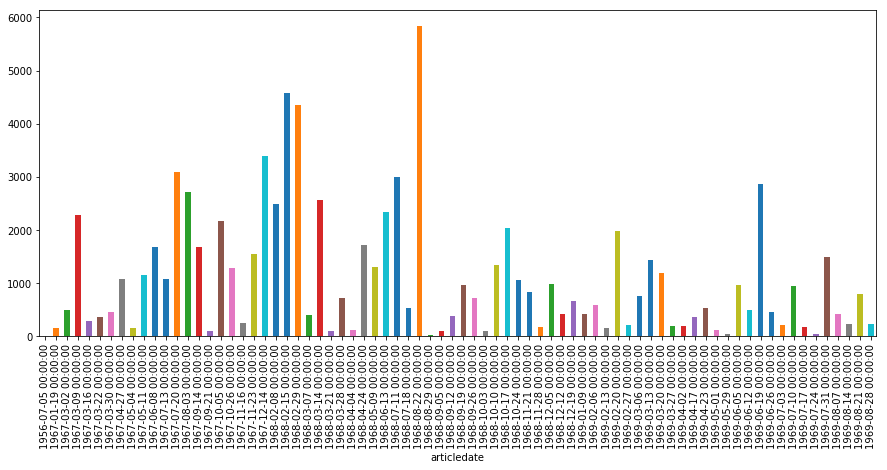

In [30]:
by_year = names.groupby('articledate').size().sort_index()
print(by_year.index.min(), by_year.index.max())
plt.figure(figsize=(15,6))
by_year.plot.bar()

To generate a plot of the frequency by month we need to add a new column to the dataframe which is the month extracted from the article date (not using the date from the text here as it is unreliable).  We can see the same peak of cases in February observed by the NLA team at ResBaz.

1 12


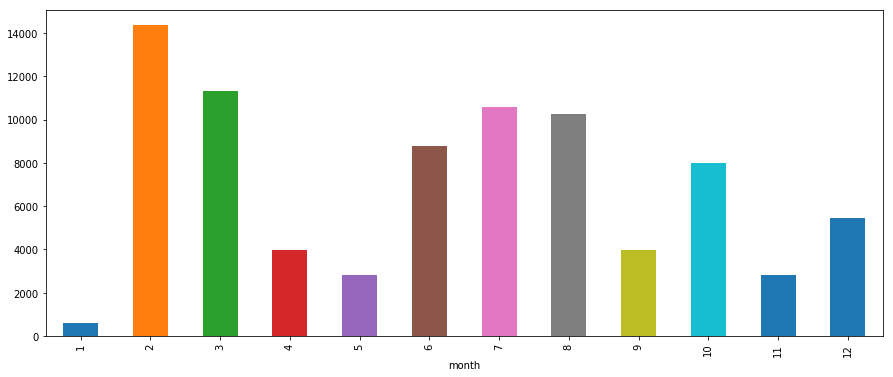

In [31]:
names['month'] = [x.month for x in names['articledate']]
by_month = names.groupby('month').size().sort_index()
print(by_month.index.min(), by_month.index.max())
plt.figure(figsize=(15,6))
by_month.plot.bar()